In [7]:
%load_ext autoreload
%autoreload 2
from neural import Neural
from utilities import evaluate_model_parallel, plot_TR_VAL, train_and_evaluate, plot_compare, mee
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from numpy import mean, std

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CUP dataset loading

In [8]:
names=["ID", "INPUT1", "INPUT2", "INPUT3", "INPUT4", "INPUT5", "INPUT6", "INPUT7", "INPUT8", "INPUT9", "INPUT10", "TARGET_x", "TARGET_y", "TARGET_z"]
df = pd.read_csv("CUP/ML-CUP23-TR.csv", skiprows=7, sep=",", names=names)

X = df.iloc[:, 1:11].to_numpy()
y = df.iloc[:, -3:].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Grid search

### Parameter Grid

In [7]:
param_grid = {
    'layer_structure': [
        [X_train.shape[1], 10,20,10, y_train.shape[1]],
        [X_train.shape[1], 32,64,32, y_train.shape[1]]
    ],
    'epochs': [512],
    'batch_size': [16,32, 64],
    'learning_rate': [0.1, 0.01, 0.001],
    'optimizer':['nesterov'],
    'momentum': [0.98, 0.95, 0.90, 0.0],
    'l2_lambda': [0, 0.001, 0.0001],
    'hidden_function': ['sigmoid', 'relu', 'tanh'],
    'output_function' :['linear'],
    'init_method': ['he'],
    'momentum_schedule': [True,False]
}
import itertools
keys, values = zip(*param_grid.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

permutations_dicts = [
    d for d in permutations_dicts 
    if not (
        (d['optimizer'] == 'adam' and d['momentum'] > 0) or
        (d['optimizer'] == 'nesterov' and d['momentum'] == 0 and not d['momentum_schedule']) or
        (d['optimizer'] == 'adam' and d['momentum_schedule']) or
        (d['optimizer'] == 'nesterov' and d['momentum_schedule'] and d['momentum'] > 0)
    )
]
len(permutations_dicts)

648

### Parallel grid search

In [ ]:
from joblib import Parallel, delayed
from joblib_progress import joblib_progress

with joblib_progress("Grid search", total=len(permutations_dicts)):
    res=Parallel(n_jobs=-1)(delayed(evaluate_model_parallel)(Neural, param, X_train, y_train,n_folds=5,n_repeats=3) for param in permutations_dicts)

Output()

### Best hyperparameters

In [84]:
best_mse = float("inf")
best_res = []
for r in res:
    if mean(r[1])<best_mse:
        best_mse = mean(r[1])
        best_res = r
best_res

[{'layer_structure': [10, 32, 64, 32, 3],
  'epochs': 512,
  'batch_size': 64,
  'learning_rate': 0.005,
  'optimizer': 'nesterov',
  'momentum': 0,
  'l2_lambda': 0.001,
  'hidden_function': 'sigmoid',
  'output_function': 'linear',
  'init_method': 'he',
  'momentum_schedule': True},
 [0.1693809521015609,
  0.39784821878906973,
  0.1680950618502645,
  0.26476244372539864,
  0.2739259775965784,
  0.22286445941230812,
  0.21583075521598363,
  0.15147185987193487,
  0.18557650008539586,
  0.3687977733282031,
  0.25399076095044926,
  0.21260073388495349,
  0.2923524985653025,
  0.2543460506411581,
  0.24750829543553557,
  0.13029631556606247,
  0.17053723911006813,
  0.1959202604394267,
  0.2881703318373818,
  0.16058990468202056]]

### BEST MODEL FOUND

In [8]:
best_result = {'layer_structure': [10, 32, 64, 32, 3],
 'epochs': 512,
 'batch_size': 64,
 'learning_rate': 0.005,
 'optimizer': 'nesterov',
 'momentum': 0.0,
 'l2_lambda': 0.001,
 'hidden_function': 'sigmoid',
 'output_function': 'linear',
 'init_method': 'he',
 'momentum_schedule': True}

In [9]:
#nn.reset()

nn = Neural(best_result['layer_structure'], 
            epochs = best_result['epochs'], 
            batch_size = best_result['batch_size'],
            learning_rate = best_result['learning_rate'],
            hidden_function = best_result['hidden_function'],
            output_function = best_result['output_function'],
            init_method = best_result['init_method'],
            optimizer=best_result['optimizer'],
            momentum = best_result['momentum'],
            l2_lambda = best_result['l2_lambda'],
            momentum_schedule = best_result['momentum_schedule'],
            early_stopping=True,
            patience=10,
            verbose=0)
nn.fit(X_train,y_train)
print(f"train error: {mean_squared_error(nn.predict(X_train),y_train)}")
print(f"Test error: {mean_squared_error(nn.predict(X_test),y_test)}")

train error: 0.03527742831788436
Test error: 0.28691876203963046


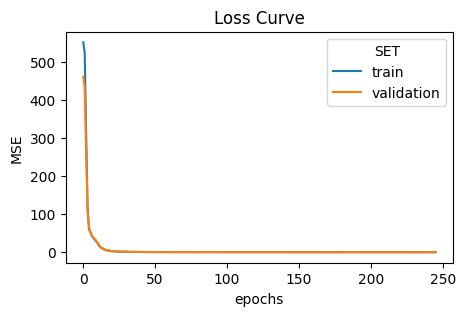

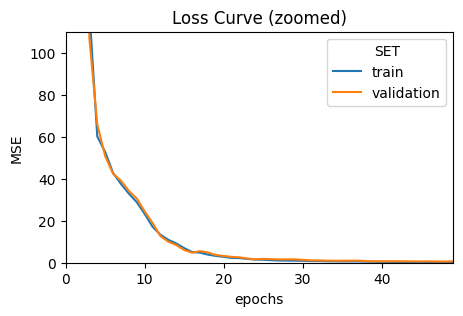

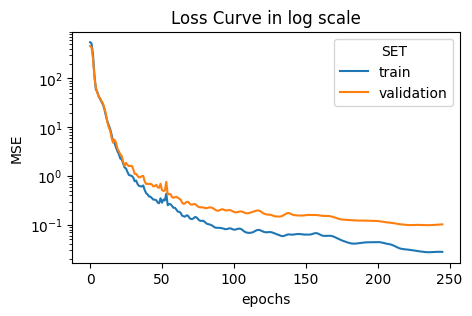

In [10]:
plot_TR_VAL(nn, title='Loss Curve', zoom_factor=0, log_scale=False, figsize=(5,3))
plot_TR_VAL(nn, title='Loss Curve (zoomed)', zoom_factor=5, log_scale=False, figsize=(5,3))
plot_TR_VAL(nn, title='Loss Curve in log scale', zoom_factor=0, log_scale=True, figsize=(5,3))

In [26]:
#Check the robustness of the best model found

train_and_evaluate(nn, X_train, y_train, X_test, y_test, n_iterations=20)

Mean Train Loss      Mean Test Loss       Std Train Loss       Std Test Loss       
--------------------------------------------------------------------------------
0.0556               0.2846               0.0232               0.0634              


Mean Train MEE       Mean Test MEE        Std Train MEE        Std Test MEE        
--------------------------------------------------------------------------------
0.3207               0.6330               0.0619               0.0584              


# Generate the blind test labels

In [9]:
names=["ID", "INPUT1", "INPUT2", "INPUT3", "INPUT4", "INPUT5", "INPUT6", "INPUT7", "INPUT8", "INPUT9", "INPUT10"]
df_blind = pd.read_csv("CUP/ML-CUP23-TS.csv", skiprows=7, sep=",", names=names)

X_blind = df_blind.iloc[:, 1:11].to_numpy()

In [14]:
best_result = {'layer_structure': [10, 32, 64, 32, 3],
 'epochs': 512,
 'batch_size': 64,
 'learning_rate': 0.005,
 'optimizer': 'nesterov',
 'momentum': 0.0,
 'l2_lambda': 0.001,
 'hidden_function': 'sigmoid',
 'output_function': 'linear',
 'init_method': 'he',
 'momentum_schedule': True}

nn = Neural(best_result['layer_structure'], 
            epochs = best_result['epochs'], 
            batch_size = best_result['batch_size'],
            learning_rate = best_result['learning_rate'],
            hidden_function = best_result['hidden_function'],
            output_function = best_result['output_function'],
            init_method = best_result['init_method'],
            optimizer=best_result['optimizer'],
            momentum = best_result['momentum'],
            l2_lambda = best_result['l2_lambda'],
            momentum_schedule = best_result['momentum_schedule'],
            early_stopping=True,
            patience=10,
            verbose=0)
nn.fit(X_train,y_train)
print(f"train error: {mean_squared_error(nn.predict(X_train),y_train)}")
print(f"Test error: {mean_squared_error(nn.predict(X_test),y_test)}")

train error: 0.04587394510320264
Test error: 0.2194632574272176


In [30]:
predictions = nn.predict(X_blind)
header = [
    "# Michele Velardita, Paolo Andriani",
    "# All'ultimo momentum",
    "# ML-CUP23",
    "# 08/07/2024"
]
filename =  "All'ultimo momentum_ML-CUP23-TS.csv"

with open(filename, 'w') as file:
    for line in header:
        file.write(line + '\n')
    
    for i, prediction in enumerate(predictions, start=1):
        line = f"{i},{prediction[0]},{prediction[1]},{prediction[2]}"
        file.write(line + '\n')

print(f"File '{filename}' has been created successfully.")

File 'All'ultimo momentum_ML-CUP23-TS.csv' has been created successfully.
